In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [35]:

df = pd.read_csv("/content/2. drug200 (1).csv")
df

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY
...,...,...,...,...,...,...
195,56,F,LOW,HIGH,11.567,drugC
196,16,M,LOW,HIGH,12.006,drugC
197,52,M,NORMAL,HIGH,9.894,drugX
198,23,M,NORMAL,NORMAL,14.020,drugX


In [36]:
Q1 = df['Na_to_K'].quantile(0.25)
Q3 = df['Na_to_K'].quantile(0.75)
IQR = Q3 - Q1


lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR


outliers = df[(df['Na_to_K'] < lower_bound) | (df['Na_to_K'] > upper_bound)]
print("Number of outliers:", len(outliers))


median = df['Na_to_K'].median()
df['Na_to_K'] = np.where((df['Na_to_K'] < lower_bound) | (df['Na_to_K'] > upper_bound),
                              median,
                              df['Na_to_K'])

Number of outliers: 8


In [37]:
df.isnull().sum()


Age            0
Sex            0
BP             0
Cholesterol    0
Na_to_K        0
Drug           0
dtype: int64

In [38]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

categorical_columns = [
    'Sex','BP','Cholesterol','Na_to_K',
    'Drug'
]
for column in categorical_columns:
    df[column] = label_encoder.fit_transform(df[column])


df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,0,0,0,168,0
1,47,1,1,0,89,3
2,47,1,1,0,43,3
3,28,0,2,0,10,4
4,61,0,1,0,134,0


In [39]:

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import pandas as pd
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

numeric_columns = df.select_dtypes(include=['int64']).columns
categorical_columns = df.select_dtypes(include=['object']).columns


encoder = LabelEncoder()
for col in categorical_columns:
    df[col] = encoder.fit_transform(df[col])

X_numeric = df[numeric_columns].drop(columns=['Drug'])
y = df['Drug']

selector = SelectKBest(score_func=chi2, k=5)

X_numeric_new = selector.fit_transform(X_numeric, y)


selected_indices = selector.get_support(indices=True)


selected_features = X_numeric.columns[selected_indices]
print("Selected Features:")
print(selected_features)

Selected Features:
Index(['Age', 'Sex', 'BP', 'Cholesterol', 'Na_to_K'], dtype='object')


In [40]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X_numeric_new, y, test_size=0.2, random_state=42)


print("Training data shape (X_train, y_train):", X_train.shape, y_train.shape)
print("Testing data shape (X_test, y_test):", X_test.shape, y_test.shape)

Training data shape (X_train, y_train): (160, 5) (160,)
Testing data shape (X_test, y_test): (40, 5) (40,)


accuracy

In [41]:

from sklearn.naive_bayes import GaussianNB


X_train, X_test, y_train, y_test = train_test_split(X_numeric_new, y, test_size=0.2, random_state=42)

model = GaussianNB()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = np.sum(y_pred == y_test) / len(y_test)


print("Accuracy:", accuracy)


Accuracy: 0.875


conf matrix

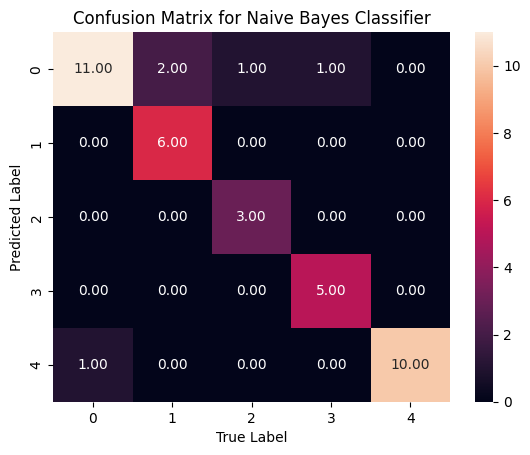

In [42]:
from sklearn.naive_bayes import GaussianNB
import seaborn as sns
import matplotlib.pyplot as plt


model.fit(X_train, y_train)

y_pred = model.predict(X_test)


cm = np.array(pd.crosstab(y_test, y_pred))

sns.heatmap(cm, annot=True, fmt=".2f")
plt.xlabel("True Label")
plt.ylabel("Predicted Label")
plt.title("Confusion Matrix for Naive Bayes Classifier")
plt.show()

classification report


In [43]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.73      0.81        15
           1       0.75      1.00      0.86         6
           2       0.75      1.00      0.86         3
           3       0.83      1.00      0.91         5
           4       1.00      0.91      0.95        11

    accuracy                           0.88        40
   macro avg       0.85      0.93      0.88        40
weighted avg       0.89      0.88      0.87        40



cross velidation

In [44]:
from sklearn.model_selection import KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score

X, y = make_classification(n_samples=1000, n_features=20, random_state=42)

nb_classifier = GaussianNB()


num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

fold_accuracy = []


for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]


    nb_classifier.fit(X_train, y_train)


    y_pred = nb_classifier.predict(X_test)


    accuracy = accuracy_score(y_test, y_pred)
    fold_accuracy.append(accuracy)


avg_accuracy = sum(fold_accuracy) / num_folds
print(f'Average accuracy across {num_folds}-fold cross-validation: {avg_accuracy:.4f}')

Average accuracy across 5-fold cross-validation: 0.8390
